<a href="https://colab.research.google.com/github/OmdenaAI/CordobaArgentinaChapter_MonitoringLandUseTransformation/blob/main/sandbox/Amine%20TEFFAL/cordobaAltara_data_pipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The purpose of this notebook is to show how you can get and display an region of interest using the Google Earth Engine python API

# Main Datasets for Global and Argentina Images

[preprocessing_service folder in Github](https://github.com/OmdenaAI/CordobaArgentinaChapter_MonitoringLandUseTransformation/tree/main/preprocessing_service)

## 1. Landsat
### Characteristics and Temporal Resolution:
- **Landsat 9** (2021-present)
  - Spatial resolution: 30m
  - Temporal resolution: 16 days
  - ID: `LANDSAT/LC09/C02/T1_L2`

- **Landsat 8** (2013-present)
  - Spatial resolution: 30m
  - Temporal resolution: 16 days
  - ID: `LANDSAT/LC08/C02/T1_L2`

- **Landsat 7** (1999-2023)
  - Spatial resolution: 30m
  - Temporal resolution: 16 days
  - Note: Has scan line issues since 2003
  - ID: `LANDSAT/LE07/C02/T1_L2`

- **Landsat 5** (1984-2012)
  - Spatial resolution: 30m
  - Temporal resolution: 16 days
  - ID: `LANDSAT/LT05/C02/T1_L2`

## 2. Sentinel
### Characteristics and Temporal Resolution:
- **Sentinel-2** (2015-present)
  - Spatial resolution: 10m, 20m, 60m (depending on band)
  - Temporal resolution: 5 days (combining Sentinel-2A and 2B)
  - Ideal for agricultural and forest monitoring
  - ID: `COPERNICUS/S2_SR`

- **Sentinel-1 SAR**
  - Spatial resolution: 10m (Ground Range Detected)
  - Temporal resolution: 6-12 days
  - Useful for areas with high cloud coverage
  - ID: `COPERNICUS/S1_GRD`

In [1]:
! pip install -q rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.2 MB/s eta 0:00:00


In [16]:
import ee
import geemap.core as geemap
import time
import matplotlib.pyplot as plt
import rasterio
import numpy as np

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

In [4]:
# Initialize the library.
ee.Initialize(project='omdenaaltara')  # you need to change this

In [69]:
# Get the polygon from user
polygon_coords = [

[-30.41127891182024, -64.1859590005123],
[-31.412450937269632, -64.12428602687949],
[-31.40922783205453, -64.16810621730917],
[-31.40453948137227, -64.16741957180136],
[-31.40453948137227, -64.1808091592037],
[-30.41127891182024,-64.1859590005123],

]


polygon = ee.Geometry.Polygon(polygon_coords)

In [70]:
# area of the polygon in squared meters
print(polygon.area().getInfo())

151222529.50728723


In [71]:
# get the centroid of polygon
print(polygon.centroid().getInfo()['coordinates'])

[-31.076966445240075, -64.16441340975918]


In [73]:
# Create a map centered on the polygon.
map = geemap.Map(center=polygon.centroid().getInfo()['coordinates'], zoom=12) # np.array(polygon_coords).mean(axis=0).tolist()

# Add the polygon to the map.
map.addLayer(polygon, {'color': 'black'}, 'Polygon')

# Display the map.
map

Map(center=[-31.076966445240075, -64.16441340975918], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [74]:
# coordinates of cordoba
#Lat : -31.4135000°
#Long : -64.1810500°

lon = -64.1859590005123
lat = -31.41127891182024
d = 0.02

# define a rectangle arround cordoba
# aoi = ee.Geometry.Rectangle([lon-d, lat-d, lon+d, lat+d])  # usage : ee.Geometry.Rectangle(minLng, minLat, maxLng, maxLat).


dataset = (
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED')  # see here : https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED
    .filterDate('2022-01-01', '2022-01-31')
    .filterBounds(polygon)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    # .map(mask_s2_clouds)
)

rgb_vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],  # need to understand bands...
}

m = geemap.Map()
m.set_center(lon, lat, 12)
m.add_layer(dataset.median(), rgb_vis, 'RGB')
m

Map(center=[-31.41127891182024, -64.1859590005123], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Transform to classic image and store it

In [75]:
dataset.first()

In [ ]:
img_tiff = dataset.first().select(['B4', 'B3', 'B2'])

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=img_tiff,
    description='rasterImage',
    #crs=projection['crs'],
    #crsTransform=projection['transform'],
    region=aoi,
    #scale=30,
)
task.start()

In [ ]:
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(30)

Polling for task (id: QTPVTGLCJXEQAYSRSFAI7NJ5).


## Read and dispaly the image

In [ ]:
image_path = "/content/drive/MyDrive/rasterImage (1).tif"

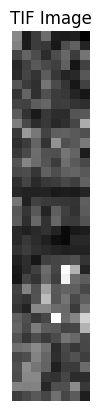

In [ ]:
# Function to read and display a TIF image
def display_tif_image(file_path):
    # Open the TIF file
    with rasterio.open(file_path) as src:
        # Read the image data
        image = src.read(1)

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title('TIF Image')
        plt.axis('off')
        plt.show()



display_tif_image(image_path)

In [ ]:
with rasterio.open(image_path) as src:
  # Read the image data
  image = src.read(1)

In [ ]:
image

array([[0.292 , 0.1364, 0.184 , 0.2533, 0.1398, 0.1393, 0.1412, 0.0984],
       [0.283 , 0.1393, 0.1839, 0.1781, 0.1331, 0.2099, 0.2371, 0.1491],
       [0.196 , 0.2407, 0.2073, 0.1625, 0.2078, 0.2466, 0.1843, 0.2644],
       [0.1552, 0.1913, 0.2273, 0.2025, 0.1888, 0.2354, 0.1292, 0.1936],
       [0.1584, 0.1972, 0.1745, 0.2297, 0.1775, 0.1512, 0.1566, 0.2235],
       [0.2184, 0.1834, 0.1661, 0.2658, 0.2056, 0.1748, 0.1317, 0.1936],
       [0.174 , 0.2413, 0.1673, 0.2127, 0.1855, 0.1788, 0.1502, 0.1306],
       [0.1938, 0.1924, 0.2307, 0.2441, 0.1856, 0.1873, 0.173 , 0.1654],
       [0.2287, 0.1709, 0.1366, 0.1799, 0.1616, 0.1638, 0.2193, 0.2275],
       [0.2786, 0.2014, 0.1636, 0.1796, 0.1567, 0.1666, 0.1984, 0.3438],
       [0.1789, 0.3163, 0.2694, 0.194 , 0.2343, 0.2386, 0.2254, 0.2127],
       [0.1641, 0.1847, 0.2414, 0.1722, 0.3066, 0.2125, 0.2251, 0.2717],
       [0.1806, 0.2048, 0.2535, 0.2161, 0.2111, 0.266 , 0.2419, 0.1393],
       [0.2186, 0.2888, 0.2528, 0.2181, 0.186 , 0.2

In [ ]:
image.shape

(38, 8)

In [48]:
import folium

In [50]:
# Create a map centered on a location
m = folium.Map(location=polygon.centroid().getInfo()['coordinates'], zoom_start=12)

In [52]:
# Create a polygon
polygon = folium.Polygon(locations=polygon_coords, color="blue", fill=True, fill_color="blue")

# Add the polygon to the map
polygon.add_to(m)

In [53]:
display(m)